# MINST Classification KNN (Centroid Approach)

- this notebook will use MINST dataset of handwritten digIts from one to 9 
- we will use only 10000 data-point for training and 1000 data-point for test as asked

#### Essintial imports 

In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import pandas as pd
%matplotlib inline
from itertools import product
from IPython.display import display, clear_output
from itertools import combinations ,combinations_with_replacement
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import namedtuple, OrderedDict
print(tf.__version__)
print(keras.__version__)


C:\Users\paula\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\paula\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\paula\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\paula\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1.14.0
2.2.4-tf


#### importing preprocessed data from keras  

In [2]:
from keras.datasets import mnist 
(xtrain , y_train) , (xtest,y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 13s 1us/step


In [3]:
print("Train samples:", xtrain.shape, y_train.shape)
print("Test samples:", xtest.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [4]:
x = xtrain.reshape(xtrain.shape[0], 1, 28*28)
x.shape

(60000, 1, 784)

##### taking small portion as asked 

In [5]:
xtrain=xtrain[50000:]
y_train=y_train[50000:]
xtest=xtest[9000:]
y_test=y_test[9000:]

In [6]:
print("Train samples:", xtrain.shape, y_train.shape)
print("Test samples:", xtest.shape, y_test.shape)

Train samples: (10000, 28, 28) (10000,)
Test samples: (1000, 28, 28) (1000,)


##### plotting digits in grey scale just for illustration 

3
5
6
9
9
3
1
9
5
1


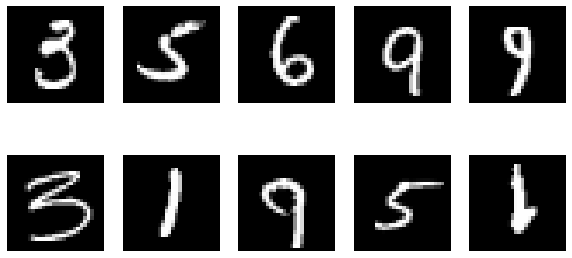

In [7]:
cols = 5
rows = 2
fig = plt.figure(figsize=(2 * cols , 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, 1000)
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(xtrain[random_index, :] ,cmap='gray')
        print(y_train[random_index])
        
plt.show()

#### Imaged_grid is function that slice the photo into certain amount of grids 

In [8]:

def imaged_grid(img , row , col ):
    x , y = img.shape
    return (img.reshape ( x //row, row, -1, col).swapaxes(1,2).reshape(-1, row, col))

(8, 14, 7)


array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]],

       [[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0, 

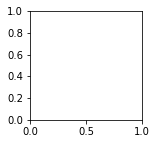

In [9]:
fig = plt.figure(figsize=(2  , 2))
ax = fig.add_subplot(1, 1, 1)
#ax.imshow(xtest[8] ,cmap='gray')
print(imaged_grid(xtest[4] , 14 , 7 ).shape)
imaged_grid(xtest[5] , 7 , 14 )




#### Get the centroid (centet of mass of grey scale) of each slice (grid) made

In [10]:
def get_centroid(img ,L):
    feature = []
    for grid in imaged_grid(img , L[0] , L[1] ) :
        X = 0 
        Y = 0 
        s = 0
        for index, bit in np.ndenumerate(grid):
          s+= bit
          X += bit * index[0]
          Y += bit * index[1]  
        if s != 0 :
            feature.append( X/ s )
            feature.append(Y/ s )
        else :
             feature.append(0)
             feature.append(0)
    return np.array(feature)


#### extracting train and test features using previous funcution 

In [11]:
l = [14,7]
trainf = [get_centroid(img,l)  for img in xtrain ]
trainf = np.array (trainf)
print (f'train feature size =>{trainf.shape}')
testf = [get_centroid(img,l)  for img in xtest]
testf = np.array (testf)
print(f'test feature size =>{testf.shape}')

train feature size =>(10000, 16)
test feature size =>(1000, 16)


In [12]:
display (trainf[0].shape , testf[0])

(16,)

array([11.5       ,  6.        ,  9.27056884,  3.00263809, 10.44494382,
        3.57512039, 10.06481481,  0.97074074, 11.08      ,  6.        ,
        8.71985583,  3.02604849,  2.50737207,  1.75390286,  0.        ,
        0.        ])

### Fitting feature using KNeighborsClassifier using ecludian distance then predict using Accuracy metric 

In [13]:
model = KNeighborsClassifier(3 , metric = 'euclidean')
model.fit (trainf , y_train)
ypred = model.predict(testf)

In [14]:
print("accuracy=", accuracy_score(y_test, ypred) )

accuracy= 0.84


# Impleminting NN from scratch 

* Get batch from the training set.
* Pass batch to network(we will build).
* Calculate the loss (difference between the predicted values and the true values).
* Calculate the gradient of the loss function w.r.t the network's weights (backward propagation).
* Update the weights using the gradients to reduce the loss.

-- We feed input data into the neural network
-- The data flows from layer to layer until we have the output.

--Once we have the output, we can calculate the error which is a scalar.

-- Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.

--We iterate through that process.

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

In [15]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [16]:
def Relu(input):
    return np.maximum (0,input)
    
def Relubackword ( input ,grad_output):
    relu_grad = input > 0
    return relu_grad

In [17]:
from IPython.display import Image
from IPython.core.display import HTML 

#PATH = "C:\\Users\\EGYPT\\Pictures\\Screenshots\\Screenshot (866).png"
#Image(filename = PATH , width=1000, height=1)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\EGYPT\\Pictures\\Screenshots\\Screenshot (866).png'

In [18]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        #Random initialization of weights for each layer [1]
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        #Multiplying weights with the input of each layer to get the output [1]
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        
        #Saving the output of each layer to use it here in backpropagation [1]
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    #the derivative of the error with respect to that layer’s output (∂E/∂Y)
    #The derivative of the error with respect to the parameters (∂E/∂W, ∂E/∂B)
    #The derivative of the error with respect to the input (∂E/∂X)
    def backward_propagation(self, output_error, learning_rate):
        #∂E/∂X = ∂E/∂Y * W.T
        input_error = np.dot(output_error, self.weights.T)
        
        #∂E/∂W = x.T * ∂E/∂Y
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        #Backward the error and calculating the update to the weights for the All layer [0.75] (easy) [1.25] (hard)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [19]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        #output_error =dE/dY
        #∂E/∂x =   dE/dY * activition drevitive 
        return self.activation_prime(self.input) * output_error
    
    
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z;

def sigmoidDrivitve(x):
    z = 1 / (1 + np.exp(-x)) * (1 - (1 / (1 + np.exp(-x))))
    return z;

def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [20]:
def mse(y_true, y_pred):
    return np.sum(np.power(y_true-y_pred, 2))/y_true.shape[0];
"""error = [(p - o) for p, o in zip(y_pred, y_true)]
    square_error = [e**2 for e in error]
    mean_square_error = sum(square_error)/len(square_error)
    return min(mean_square_error)"""


#Calculate the derivative of the MSE error [1]
def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [21]:

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    
    def add(self, layer):
        self.layers.append(layer)

    
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

   
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        for i in range(samples):
           
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result


    def fit(self, x_train, y_train, epochs, learning_rate):
  
        samples = len(x_train)

       
        for i in range(epochs):
            err = 0
            for j in range(samples):
                
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                err += self.loss(y_train[j], output)
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            err /= samples
            print(f'epoch {i+1}   error= {err}')

## Rapping all together

In [22]:
def to_categorical(y, num_classes=None, dtype='float32'):
  
  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical


In [23]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
display (y_train.shape ,y_test .shape)

(10000, 10)

(1000, 10)

In [25]:
print (trainf.shape)

"""tr = trainf.reshape(trainf.shape[0], 1, 28*28)
tr.shape"""

(10000, 16)


'tr = trainf.reshape(trainf.shape[0], 1, 28*28)\ntr.shape'

In [26]:
net = Network()
#At least 2 layers (hidden layer + output layer) [0.5]
#Number of neurons can be changed, and minimum neurons should be 4 (both for this grade) [1]
net.add(Dense(16 , 100))              
net.add(ActivationLayer(sigmoid, sigmoidDrivitve))
net.add(Dense(100, 50))                  
net.add(ActivationLayer(sigmoid, sigmoidDrivitve))
net.add(Dense(50, 10))
#Activation function (sigmoid) for the last layer [0.5]
net.add(ActivationLayer(sigmoid, sigmoidDrivitve))

In [27]:
trainff = trainf.reshape(trainf.shape[0], 1, 8*2)
display ( trainff . shape, trainf . shape)

(10000, 1, 16)

(10000, 16)

In [28]:
y_train . shape
y_trainn = y_train.reshape(y_train.shape[0], 1, 10)
display ( y_train . shape, y_train . shape)

(10000, 10)

(10000, 10)

In [29]:
net.use(mse, mse_prime)
net.fit(trainff[0:10000], y_train[0:10000], epochs=100, learning_rate=0.1)


epoch 1   error= 0.0818430472646947
epoch 2   error= 0.05898024514796989
epoch 3   error= 0.04811941106331205
epoch 4   error= 0.04262237780632218
epoch 5   error= 0.03874070826595906
epoch 6   error= 0.03566315281869009
epoch 7   error= 0.033168682405116806
epoch 8   error= 0.03115770432074519
epoch 9   error= 0.02953719570091871
epoch 10   error= 0.028244340353185505
epoch 11   error= 0.027198539979734204
epoch 12   error= 0.026336294779942322
epoch 13   error= 0.02561866348937928
epoch 14   error= 0.025017740771147066
epoch 15   error= 0.0245056534297389
epoch 16   error= 0.024060133622226944
epoch 17   error= 0.023665806642320673
epoch 18   error= 0.02331156413598243
epoch 19   error= 0.022988920808802698
epoch 20   error= 0.02269127233887582
epoch 21   error= 0.022413668340931666
epoch 22   error= 0.022152580627295443
epoch 23   error= 0.02190544913967608
epoch 24   error= 0.021670274426931327
epoch 25   error= 0.02144557264849439
epoch 26   error= 0.02123042705255851
epoch 27   e

In [30]:
summ = 0
#Transforming output vector into a label [0.5]
out = net.predict(testf[0:1000])
for i in range (len(out)):
    
    l = max(out[i][0])
    max_index = np.where(out[i][0] == l)
    pred = max_index [0][0]
    
    max_index_test = np.where(y_test[i] == 1)
    max_index_test[0] [0]
    
    
    #Comparing and getting the % [0.5]
    if (pred == max_index_test):summ+=1
        



In [31]:
Acc = (summ / len(out)) * 100
#Comparing and getting the % [0.5]
print (f"there is {summ} correct sample out of {len(out)} sample")
print (f"Accurcy = {Acc} %")

there is 855 correct sample out of 1000 sample
Accurcy = 85.5 %
